In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np

from sky_spot import utils
from plot import *

sns.set_style('whitegrid')

InitMatplotlib(7, 7)

RESTART_OVERHEAD_HOURS = 0.2
DDL = 'search'
TASK = 48
results_path = f'../../results/real/ddl={DDL}+task={TASK}+overhead={RESTART_OVERHEAD_HOURS:.2f}'

dfs = []

for result_path in os.listdir(results_path):
    if not result_path.endswith('.csv'):
        continue
    df = pd.read_csv(os.path.join(results_path, result_path))
    df['env_path'] = result_path
    print(result_path, df['avg_spot_hours'].values[0], df['avg_wait_hours'].values[0])
    df['spot_fraction'] = df['avg_spot_hours'] / (df['avg_wait_hours'] + df['avg_spot_hours'])
    if 'deadline_hours' in df.columns:
        df['task_fraction'] = df['task_duration_hours'] / df['deadline_hours']
    else:
        df['task_fraction'] = df['task_duration_hours'] / DDL
    df.drop_duplicates(inplace=True)
    dfs.append(df)
dfs = pd.concat(dfs, ignore_index=True)

use_tex True 
font_size 7 
title_size 7
us-west-2b_v100_1.csv 1.962962962962963 1.3351851851851853
us-west-2a_k80_8.csv 1.8258426966292136 1.4925925925925925
us-west-2b_v100_8.csv 0.579047619047619 1.1171428571428572
us-west-2a_v100_1.csv 2.290262172284645 1.056818181818182
us-west-2b_k80_8.csv 1.28641975308642 0.9123456790123456
us-west-2a_k80_1.csv 6.5852713178294575 0.3253968253968253
us-west-2b_k80_1.csv 1.700757575757576 5.045454545454546
us-west-2a_v100_8.csv 0.6913145539906104 1.3892773892773893


In [7]:
def get_cost_saving_percentage(df, on_demand_df):
    merged = pd.merge(df, on_demand_df, on=['env_path', 'deadline_hours'], suffixes=('_origin', '_on_demand'))
    merged['cost_saving_percentage'] = (merged['avg_cost_on_demand'] - merged['avg_cost_origin']) / merged['avg_cost_on_demand']
    merged = merged.rename(columns={'strategy_origin': 'strategy', 'spot_fraction_origin': 'spot_fraction', 'task_fraction_origin': 'task_fraction', 'avg_spot_hours_origin': 'avg_spot_hours', 'deadline_hours_origin': 'deadline_hours'})
    return merged[['strategy', 'deadline_hours', 'spot_fraction', 'task_fraction', 'avg_spot_hours', 'cost_saving_percentage']]

def plot_scatter_for_avg(ax, strategy='strawman', **kwargs):
    df = dfs[dfs['strategy'] == strategy]
    on_demand_df = dfs[dfs['strategy'] == 'on_demand']
    df = get_cost_saving_percentage(df, on_demand_df)
    df = df[df['spot_fraction'] > 0.4]
    
    sns.scatterplot(data=df, x='deadline_hours', y='spot_fraction', hue='cost_saving_percentage', s=100, ax=ax, **kwargs)

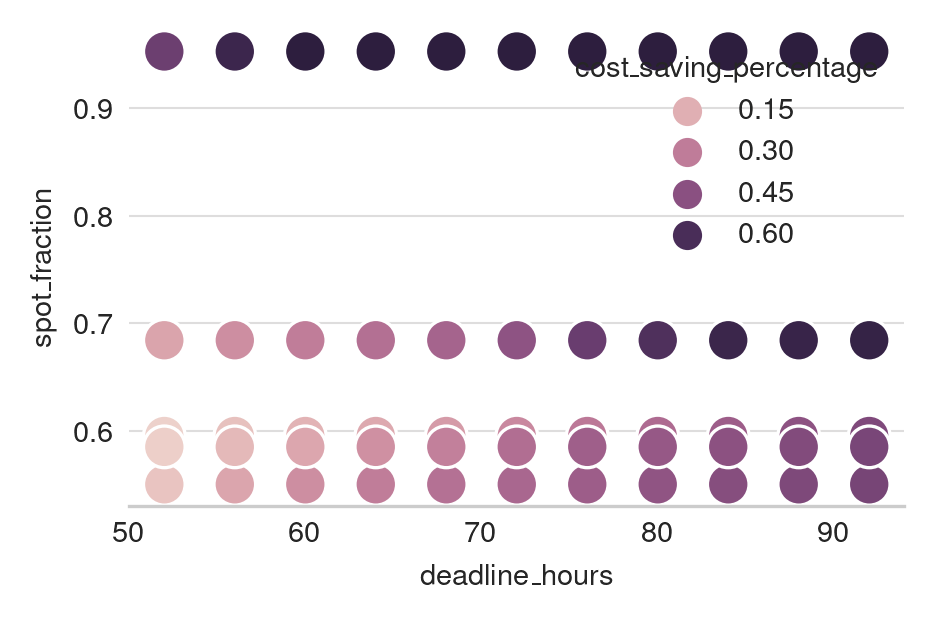

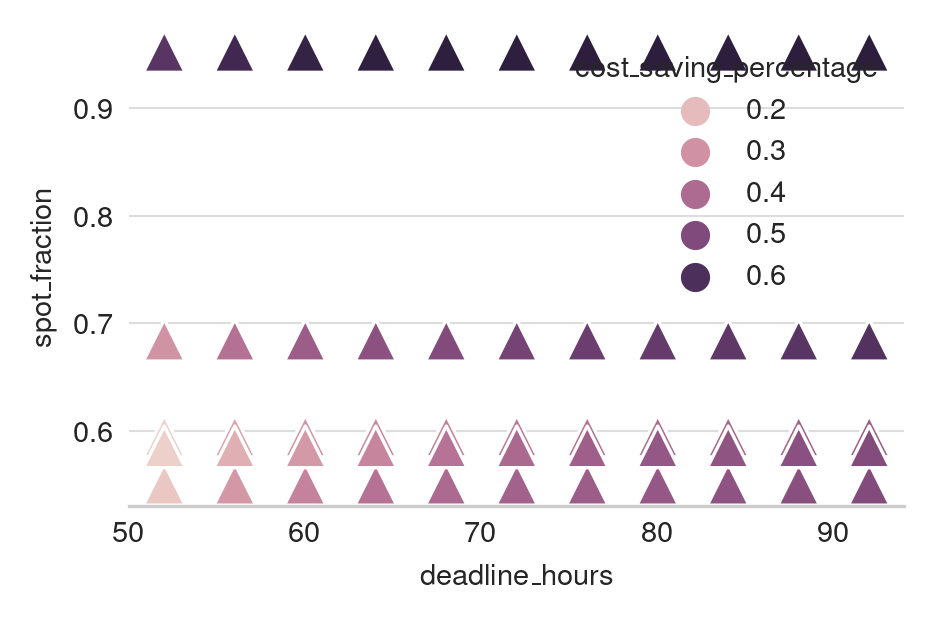

In [8]:
fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
ax = fig.subplots()
plot_scatter_for_avg(ax, strategy='strawman')
fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
ax = fig.subplots()
plot_scatter_for_avg(ax, strategy='rc_v2dt_threshold', marker='^')

In [29]:
def get_strategy_cost(x, strategy):
    strategy_df = x[x['strategy'] == strategy]
    if strategy_df.empty:
        return np.nan
    return x[x['strategy'] == strategy]['avg_cost'].values[0]

def get_optimal_gap(x):
    # return (get_strategy_cost(x, 'strawman') - get_strategy_cost(x, 'rc_v2dt_threshold')) / get_strategy_cost(x, 'strawman')
    optimal_cost = get_strategy_cost(x, 'ideal_ilp_overhead')
    greedy_optimal = get_strategy_cost(x, 'strawman') - optimal_cost
    ours_optiomal = get_strategy_cost(x, 'rc_v2dt_threshold') - get_strategy_cost(x, 'ideal_ilp_overhead')
    if greedy_optimal / optimal_cost < 0.1:
        return 0
    return greedy_optimal / ours_optiomal

In [33]:
result_df = dfs.groupby(['spot_fraction', 'deadline_hours', 'task_fraction']).apply(lambda x: get_optimal_gap(x)).reset_index().rename(columns={0: 'optimal_gap'})
result_df


,spot_fraction,deadline_hours,task_fraction,optimal_gap
0,0.252106,52,0.923077,0.0
1,0.252106,56,0.857143,0.0
2,0.252106,60,0.800000,0.0
3,0.252106,64,0.750000,0.0
4,0.252106,68,0.705882,0.0
...,...,...,...,...
83,0.952914,76,0.631579,0.0
84,0.952914,80,0.600000,0.0
85,0.952914,84,0.571429,0.0
86,0.952914,88,0.545455,0.0


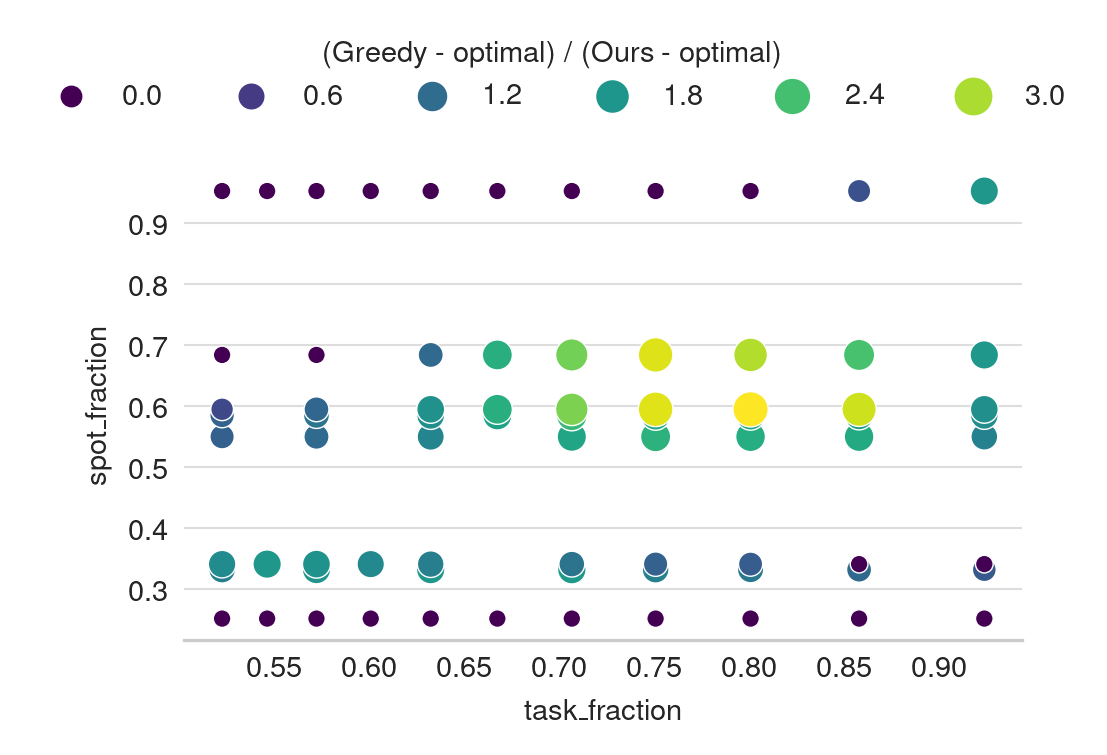

In [37]:
# fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
# ax = fig.subplots()
# sns.lineplot(data=result_df, x='task_fraction', y='optimal_gap', hue='spot_fraction', legend='auto', linewidth=1, ax=ax)
# result_df = result_df[result_df['task_fraction'] > 0.6]
fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
ax = fig.subplots()
sns.scatterplot(data=result_df, x='task_fraction', y='spot_fraction', hue='optimal_gap', s=100, ax=ax, legend='auto', size='optimal_gap', palette='viridis')
ax.legend().set_visible(False)

fig.legend(title='(Greedy - optimal) / (Ours - optimal)',
           loc='upper center',
           ncol=6,
           handles=ax.get_legend_handles_labels()[0],
           bbox_to_anchor=(0.5, 1.2))
fig.tight_layout()
fig.savefig('figures/real_strategies.pdf', bbox_inches='tight')

In [35]:
greedy_df = dfs[dfs['strategy'] == 'strawman']
ours = dfs[dfs['strategy'] == 'rc_v2dt_threshold']
on_demand_df = dfs[dfs['strategy'] == 'on_demand']
optimal_df = dfs[dfs['strategy'] == 'ideal_ilp_overhead']


